# EOFs and PCs

In [220]:
import numpy as np
import seaborn as sns
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import xarray as xr

sns.set_context('talk')

## Idea of EOF / PC

In [145]:
np.random.seed(0)
distr = sp.stats.multivariate_normal(mean=(1, 2.), cov=((2.5, .7), (.5, .7)))
data = distr.rvs(1000)

pc, s, eof = sp.linalg.svd(
    data - data.mean(axis=0),
    full_matrices=False
)

pc_std = pc.std(axis=0)
pc /= pc_std
mode = np.arange(len(pc_std)) + 1

eof *= s[:, np.newaxis] * pc_std[:, np.newaxis]

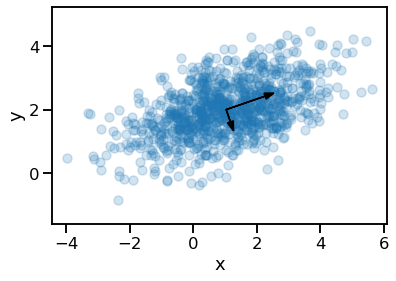

In [146]:
plt.scatter(*data.T, alpha=.2, rasterized=True)
plt.arrow(*data.mean(axis=0), *eof[0], head_width=0.2, length_includes_head=True, fc='k', ec='k')
plt.arrow(*data.mean(axis=0), *eof[1], head_width=0.2, length_includes_head=True, fc='k', ec='k')
plt.axis('equal')
plt.ylabel('y')
plt.xlabel('x');
plt.savefig('../img/10_eof_illustration.svg', bbox_inches='tight', pad_inches=.1);

In [6]:
lsmask = xr.open_dataset('../data/lsmask.nc').isel(time=0).mask
sst = xr.open_dataset('../data/sst.mnmean.nc').sst.where(lsmask)
sst_clim = sst.groupby('time.month').mean(dim='time')

# compute anomalies
sst = (sst.groupby('time.month') - sst_clim).drop('month')

/home/mclaus/anaconda3/envs/climdat/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [7]:
# Compute EOFs, PCs and exp. Var
def pca(data, dim1, dim2):
    x = data.stack(tmp_space=dim2)
    x_droped = x.dropna(dim='tmp_space')

    pc, s, eof = sp.linalg.svd(x_droped, full_matrices=False)

    pc_std = pc.std(axis=0)
    pc /= pc_std
    mode = np.arange(1, len(pc_std) + 1)
    pc = pc.T
    pc = xr.DataArray(
        pc,
        dims=('mode', dim1),
        coords={'mode': mode, dim1: x[dim1]}
    )

    exp_var = s**2 / (s**2).sum()

    eof *= pc_std[:, np.newaxis]
    eof *= s[:, np.newaxis]

    eofs = x.copy()
    eofs[:, eofs[0].notnull().values] = eof
    eofs = eofs.unstack(dim='tmp_space').rename(**{dim1: 'mode'})
    eofs.coords['mode'] = mode
    
    return pc, eofs, exp_var

In [8]:
pc, eof, exp_var = pca(sst, 'time', ('lat', 'lon'))

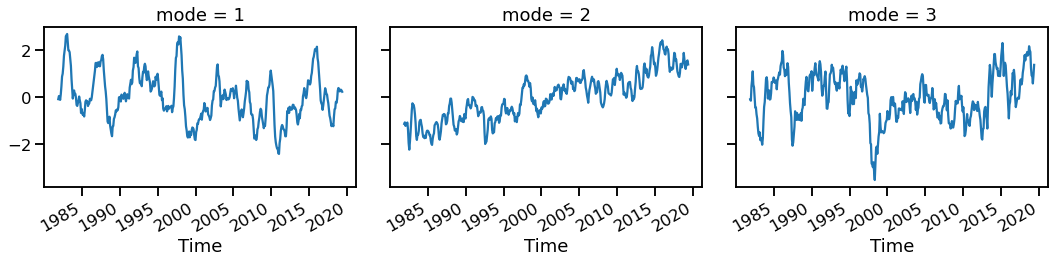

In [9]:
pc.sel(mode=slice(1, 3)).plot(col='mode', figsize=(15, 4));
plt.savefig('../img/10_eof_1.svg', bbox_inches='tight', pad_inches=.1);

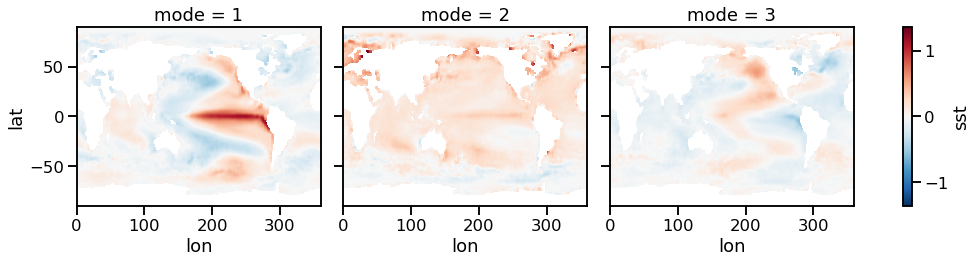

In [10]:
eof.sel(mode=slice(1, 3)).plot(col='mode', figsize=(15, 4), rasterized=True);
plt.savefig('../img/10_eof_2.svg', bbox_inches='tight', pad_inches=.1);

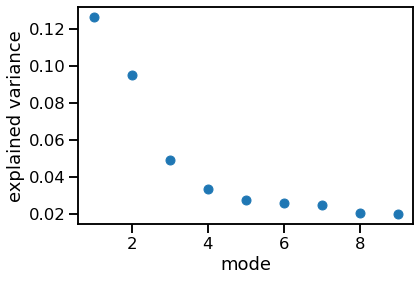

In [11]:
plt.plot(np.arange(1, 10), exp_var[:9], 'o');
plt.xlabel('mode');
plt.ylabel('explained variance');
plt.savefig('../img/10_eof_3.svg', bbox_inches='tight', pad_inches=.1);

## Notes of caution

In [283]:
np.random.seed(0)
distr = sp.stats.multivariate_normal(cov=((2.5, .7), (.7, .7)))

data = distr.rvs(50)
data -= data.mean(axis=0)

center = np.array((4.5, 1.8))

data1 = np.vstack(
    (data + center,
     data.dot(np.array(((0, 1), (-1, 0)))) - center
    ),
)

data2 = distr.rvs(100) * .75
data2[:, 1] = data2[:, 0] ** 2 + np.random.randn(100)
np.random.shuffle(data1)
# np.random.shuffle(data2)

In [289]:
def caution_plot(data):
    pc, s, eof = sp.linalg.svd(
        data - data.mean(axis=0),
        full_matrices=False
    )
    pc_std = pc.std(axis=0)
    pc /= pc_std
    mode = np.arange(len(pc_std)) + 1
    eof *= s[:, np.newaxis] * pc_std[:, np.newaxis]

    fig = plt.figure(figsize=(10, 5), constrained_layout=True)
    spec = gridspec.GridSpec(ncols=3, nrows=2, figure=fig)

    ax1 = fig.add_subplot(spec[:, :2])
    ax2 = fig.add_subplot(spec[0, 2])
    ax3 = fig.add_subplot(spec[1, 2])

    ax1.scatter(*data.T, alpha=.2, rasterized=True)
    ax1.arrow(*data.mean(axis=0), *eof[0], head_width=0.3, length_includes_head=True, fc='k', ec='k')
    ax1.arrow(*data.mean(axis=0), *eof[1], head_width=0.3, length_includes_head=True, fc='k', ec='k')
    ax1.axis('equal')
    ax1.set_ylabel('y')
    ax1.set_xlabel('x');
    ax1.set_title('Data and EOFs');

    ax2.plot(pc[:, 0], '.')
    ax2.set_ylabel("PC1")
    # ax2.set_xlabel("time")

    ax3.plot(pc[:, 1], '.')
    ax3.set_ylabel("PC1")
    ax3.set_xlabel("time")

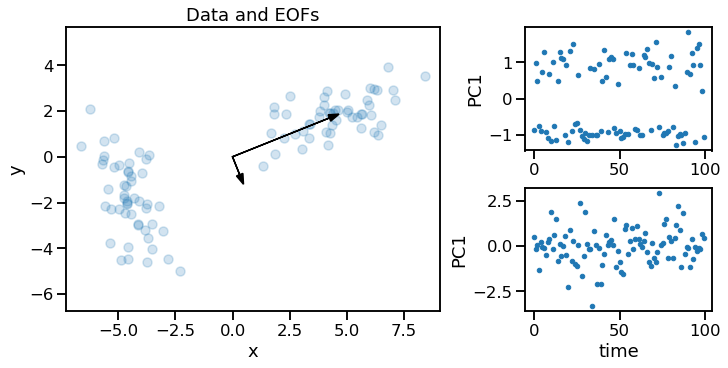

In [290]:
caution_plot(data1)
plt.savefig('../img/10_eof_caution1.svg', bbox_inches='tight', pad_inches=.1);

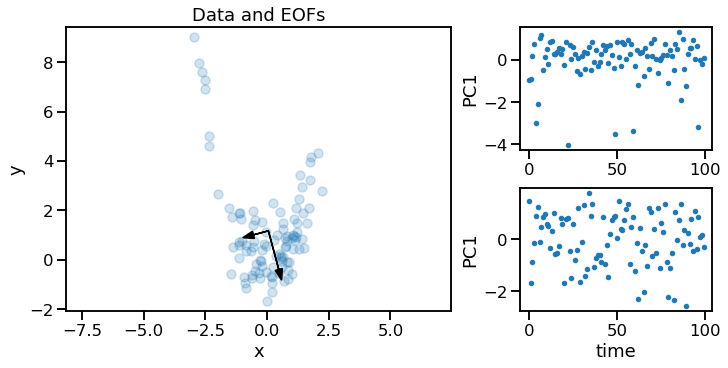

In [291]:
caution_plot(data2)
plt.savefig('../img/10_eof_caution2.svg', bbox_inches='tight', pad_inches=.1);

## Example NAO

In [12]:
slp = xr.open_dataset('../data/slp.mon.mean.nc').slp.roll(lon=70)
slp.assign_coords(lon=(((slp.lon + 180) % 360) - 180))

slp = (
    slp.groupby('time.month')
    - slp.groupby('time.month').mean()
).drop('month')

slp_D = slp.sel(time=slp['time.month']==12)
slp_J = slp.sel(time=slp['time.month']==1)
slp_F = slp.sel(time=slp['time.month']==2)
slp_M = slp.sel(time=slp['time.month']==3)

/home/mclaus/anaconda3/envs/climdat/lib/python3.8/site-packages/xarray/core/dataarray.py:2822: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  ds = self._to_temp_dataset().roll(


In [13]:
slp_DJFM = slp_D.values + slp_J.values[1:] + slp_F.values[1:] + slp_M.values[1:]

In [14]:
slp_D[:] = slp_DJFM

In [15]:
slp = slp_D.sel(lat=slice(80,20), lon=slice(270,40))

In [16]:
x = slp.stack(tmp_space=('lat', 'lon'))

pc, s, eof = sp.linalg.svd(x, full_matrices=False)

pc_std = pc.std(axis=0)
pc /= pc_std
mode = np.arange(1, len(pc_std) + 1)
pc = pc.T
pc = xr.DataArray(
    pc,
    dims=('mode', 'time'),
    coords={'mode': mode, 'time': x['time']}
)

exp_var = s**2 / (s**2).sum()

eof *= pc_std[:, np.newaxis]
eof *= s[:, np.newaxis]
eof = eof.reshape(-1, *slp.shape[1:])

# eof = xr.DataArray(
#     eof,
#     dims=('mode', 'lat', 'lon'),
#     coords={'mode': mode, 'lat': slp['lat'], 'lon': slp['lon']}
# )

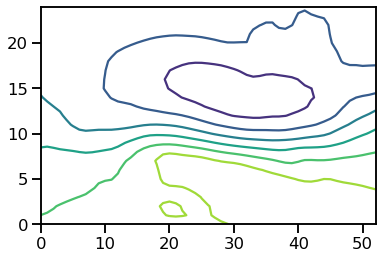

In [17]:
plt.contour(eof[0])